Training a neural network to predict $\delta C_9$ on an event-by-event basis (classification)

Import Libraries

In [1]:
from pathlib import Path
import pickle

import numpy as np
from scipy.special import logsumexp

import matplotlib as mpl
from matplotlib import pyplot as plt

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import CrossEntropyLoss
from torch.nn.functional import log_softmax

from library.plotting import setup_high_quality_mpl_params, plot_loss_curves, plot_prediction_linearity, make_plot_note
from library.datasets import Aggregated_Signal_Binned_Dataset
from library.util import bootstrap_over_bins
from library.nn_training import select_device, train_and_eval, Custom_Model


# setup_high_quality_mpl_params()


Define Helper Functions

In [2]:

def predict_log_probabilities(x, model):
    """
    Predict the log probability of each class, given a set of events.

    x : A torch tensor of features of events.
    """
    model.eval()
    with torch.no_grad():
        event_logits = model(x)
        event_log_probabilities = log_softmax(event_logits, dim=1)
        set_logits = torch.sum(event_log_probabilities, dim=0)
        set_log_probabilities = log_softmax(set_logits, dim=0)
    return set_log_probabilities


def predict_log_probabilities_by_label(x, y, model):
    """
    Predict the log probability of each class for each subset of same labeled events.
    
    x : A torch tensor of features of events (from multiple labels).
    y : A torch tensor of event labels.
    """
    labels = np.unique(y.cpu())
    log_probabilities = []
    for label in labels:
        features_label = x[y==label]
        log_probabilities_label = predict_log_probabilities(features_label, model).cpu().numpy()
        log_probabilities.append(np.expand_dims(log_probabilities_label, axis=0))
    log_probabilities = np.concatenate(log_probabilities, axis=0)
    assert log_probabilities.shape[0] == len(labels)
    return log_probabilities


def calculate_predicted_expected_value_by_label(predictions, bin_values):
    """
    Calculate the predicted expected binned value for each subset of same labeled events, given 
    the predicted probability distribution for each subset.

    predictions : numpy array of predicted probability distributions for each label.
    bin_values : numpy array of the value corresponding to each bin.
    """
    bin_value_shift = np.abs(np.min(bin_values)) + 1
    shifted_bin_values = bin_values + bin_value_shift
    log_shifted_bin_values = np.tile(np.log(shifted_bin_values), (len(shifted_bin_values), 1))
    log_shifted_expected_values = logsumexp(predictions + log_shifted_bin_values, axis=1)
    shifted_expected_values = np.exp(log_shifted_expected_values)
    expected_values = shifted_expected_values - bin_value_shift
    return expected_values


def plot_log_probabilities_over_labels(fig, ax, predictions, bin_values, cmap=plt.cm.viridis):
    """
    Plot the predicted log probability of each class for each subset of same labeled events.

    predictions : A numpy array of set probabilities (rows correspond to labels, columns correspond to class predictions).
    bin_values : A numpy array of the value each bin represents. 
    """

    color_bounds = np.append(bin_values, bin_values[-1] + (bin_values[-1] - bin_values[-2]))
    color_norm = mpl.colors.BoundaryNorm(color_bounds, cmap.N)

    for value, curve in zip(bin_values, predictions):
        ax.plot(bin_values, curve, color=cmap(color_norm(value)))

    fig.colorbar(mpl.cm.ScalarMappable(norm=color_norm, cmap=cmap), ax=ax, label=r"Actual $\delta C_9$")
    ax.set_xlabel(r"$\delta C_9$")
    ax.set_ylabel(r"$\log p(\delta C_9 | x_1, ..., x_N)$")


def plot_expected_value_over_labels(ax, expected_values, bin_values):
    """
    Plot the predicted expected value for each label.
    """
    ax.scatter(bin_values, expected_values, label="Prediction", color="firebrick", s=16, zorder=5)
    ax.plot(
        bin_values, bin_values,
        label="Ref. Line (Slope = 1)",
        color="grey",
        linewidth=0.5,
        zorder=0
    )
    ax.set_xlabel(r"Actual $\delta C_9$")
    ax.set_ylabel(r"Predicted $\delta C_9$")
    ax.legend()


Select Device

In [3]:
device = select_device()

Device:  cuda


Define Model

In [5]:
class Event_By_Event_NN(Custom_Model):
    def __init__(self, nickname, model_dir):
        super().__init__(nickname, model_dir)

        self.base = nn.Sequential(
            nn.Linear(4, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 44),
         )
        
        self.double()

    def forward(self, x):
        event_logits = self.base(x)
        return event_logits
        


Load / Generate Datasets

In [6]:
regenerate = False

level = "gen"
save_dir = "../../state/new_physics/data/processed"
raw_signal_dir = "../../state/new_physics/data/raw/signal"

std_scale = True
q_squared_veto = True

datasets = {
    "train": Aggregated_Signal_Binned_Dataset(level=level, split="train", save_dir=save_dir),
    "eval": Aggregated_Signal_Binned_Dataset(level=level, split="eval", save_dir=save_dir),
}

if regenerate:
    datasets["train"].generate(
        raw_trials=range(1,20), 
        raw_signal_dir=raw_signal_dir, 
        std_scale=std_scale, 
        q_squared_veto=q_squared_veto
    )
    datasets["eval"].generate(
        raw_trials=range(20,40), 
        raw_signal_dir=raw_signal_dir, 
        std_scale=std_scale, 
        q_squared_veto=q_squared_veto
    )

datasets["train"].load(device)
datasets["eval"].load(device)

np.testing.assert_equal(datasets["train"].bin_values, datasets["eval"].bin_values)

Loaded data with features size: torch.Size([6086564, 4]) and labels size: torch.Size([6086564]).
Loaded data with features size: torch.Size([6468396, 4]) and labels size: torch.Size([6468396]).


Train / Load Model

In [ ]:
retrain = False

model = Event_By_Event_NN("event_by_event_nn", "../../state/new_physics/models")

if retrain:
    learning_rate = 3e-3
    epochs = 200
    train_batch_size = 10_000
    eval_batch_size = 10_000
    loss_fn = CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    loss_table = train_and_eval(
        model, 
        datasets["train"], datasets["eval"], 
        loss_fn, optimizer, 
        epochs, 
        train_batch_size, eval_batch_size, 
        device, 
        move_data=True,
        scheduler= ReduceLROnPlateau(optimizer, factor=0.95, threshold=0, patience=0, eps=1e-9),
        checkpoint_epochs=5,
    )
    _, ax = plt.subplots()
    plot_epoch_start = 0
    plot_loss_curves(loss_table["epoch"][plot_epoch_start:], loss_table["train_loss"][plot_epoch_start:], loss_table["eval_loss"][plot_epoch_start:], ax)
    ax.set_yscale("log")
    plt.show()
else:
    model.load_final()
    # model.load_checkpoint(epoch_number=10)
    model.to(device)

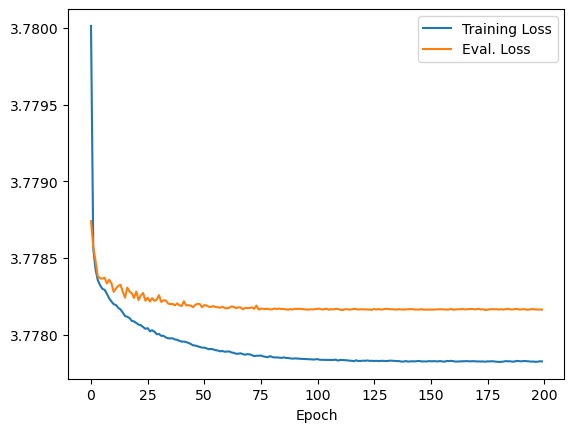

In [10]:
loss_table = model.load_loss_table()

_, ax = plt.subplots()
plot_epoch_start = 0
plot_loss_curves(loss_table["epoch"][plot_epoch_start:], loss_table["train_loss"][plot_epoch_start:], loss_table["eval_loss"][plot_epoch_start:], ax)
# ax.set_yscale("log")
plt.show()

In [ ]:
fig, ax = plt.subplots()

ax.plot(loss_table["eval_loss"][50:])
# ax.plot(loss_table["train_loss"])

plt.show()

Evaluate Model

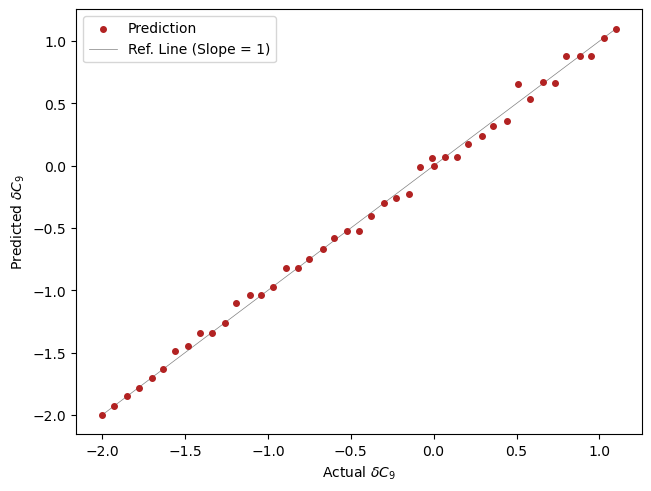

In [ ]:
model = Event_By_Event_NN("event_by_event_nn", "../../state/new_physics/models")

# for ep in range(0, 200, 5):

#     model.load_checkpoint(epoch_number=ep)
#     model.to(device)

#     fig, ax = plt.subplots(layout="constrained")

#     log_probs = predict_log_probabilities_by_label(datasets["eval"].features, datasets["eval"].labels, model)

#     expected_values = calculate_predicted_expected_value_by_label(log_probs, datasets["eval"].bin_values)
#     plot_expected_value_over_labels(ax, expected_values, datasets["eval"].bin_values)

#     # plot_log_probabilities_over_labels(fig, ax, log_probs, datasets["eval"].bin_values)

#     # make_plot_note(ax, f"About 77k events/prediction - Epoch: {ep}", fontsize="large")
#     plt.show()
#     plt.close()

#     # plt.savefig(f"plots_tmp/expected_ep_{ep}.png", bbox_inches="tight")

model.load_final()
model.to(device)

fig, ax = plt.subplots(layout="constrained")


n_bootstraps = 10
n_samples_per_bootstrap = 100
yhats = []
ys = []
for boot in range(n_bootstraps):
    sample_indices = torch.randint(0, len(datasets["eval"].labels), n_samples_per_bootstrap)
    sample_features = datasets["eval"].features[sample_indices]
    sample_labels = datasets["eval"].labels[sample_indices]
    log_probs = predict_log_probabilities_by_label(sample_indices, sample_labels, model)

expected_values = calculate_predicted_expected_value_by_label(log_probs, datasets["eval"].bin_values)
plot_expected_value_over_labels(ax, expected_values, datasets["eval"].bin_values)

# plot_log_probabilities_over_labels(fig, ax, log_probs, datasets["eval"].bin_values)

# make_plot_note(ax, "About 77k events/prediction - Epoch: 99", fontsize="large")

# plt.savefig("plots_tmp/expected_ep_99.png", bbox_inches="tight")






In [ ]:
# On evaluation data

fig, ax = plt.subplots(layout="constrained")

log_probs = predict_log_probabilities_by_label(datasets["eval"].features, datasets["eval"].labels, model)
plot_log_probabilities_over_labels(fig, ax, log_probs, datasets["eval"].bin_values)

make_plot_note(ax, "About 77k events/curve", fontsize="large")

In [ ]:
expected_values = calculate_predicted_expected_value_by_label(log_probs, datasets["eval"].bin_values)
plot_expected_value_over_labels(expected_values, datasets["eval"].bin_values)

In [ ]:
# On training data

fig, ax = plt.subplots(layout="constrained")

log_probs = predict_log_probabilities_by_label(datasets["train"].features, datasets["train"].labels, model)
plot_log_probabilities_over_labels(fig, ax, log_probs, datasets["train"].bin_values)

In [ ]:
expected_values = calculate_predicted_expected_value_by_label(log_probs, datasets["train"].bin_values)
plot_expected_value_over_labels(expected_values, datasets["train"].bin_values)

Other stuff

Linearity

In [ ]:
n_trials = 2000
n_events_per_trial = 70_000

expected_values_all_trials = []
for _ in range(n_trials):

    boot_x, boot_y = bootstrap_over_bins(
        datasets["eval"].features.cpu().numpy(), 
        datasets["eval"].labels.cpu().numpy(), 
        n_events_per_trial,
    )
    boot_x = torch.from_numpy(boot_x).to(device)
    boot_y = torch.from_numpy(boot_y).to(device)

    log_probs = predict_log_probabilities_by_label(boot_x, boot_y, model)
    expected_values = calculate_predicted_expected_value_by_label(log_probs, datasets["eval"].bin_values)
    expected_values_all_trials.append(np.expand_dims(expected_values, axis=0))

expected_values_all_trials = np.concat(expected_values_all_trials)

def calc_mse():
    dif = expected_values_all_trials - datasets["eval"].bin_values
    dif_sq = dif**2
    out = dif_sq.mean()
    return out

def calc_mae():
    dif = expected_values_all_trials - datasets["eval"].bin_values
    abs_dif = np.abs(dif)
    out = abs_dif.mean()
    return out

mse = calc_mse()
mae = calc_mae()
print("mse:", mse)
print("mae:", mae)


expected_values_all_trials_means = np.mean(expected_values_all_trials, axis=0)
expected_values_all_trials_stds = np.std(expected_values_all_trials, axis=0)

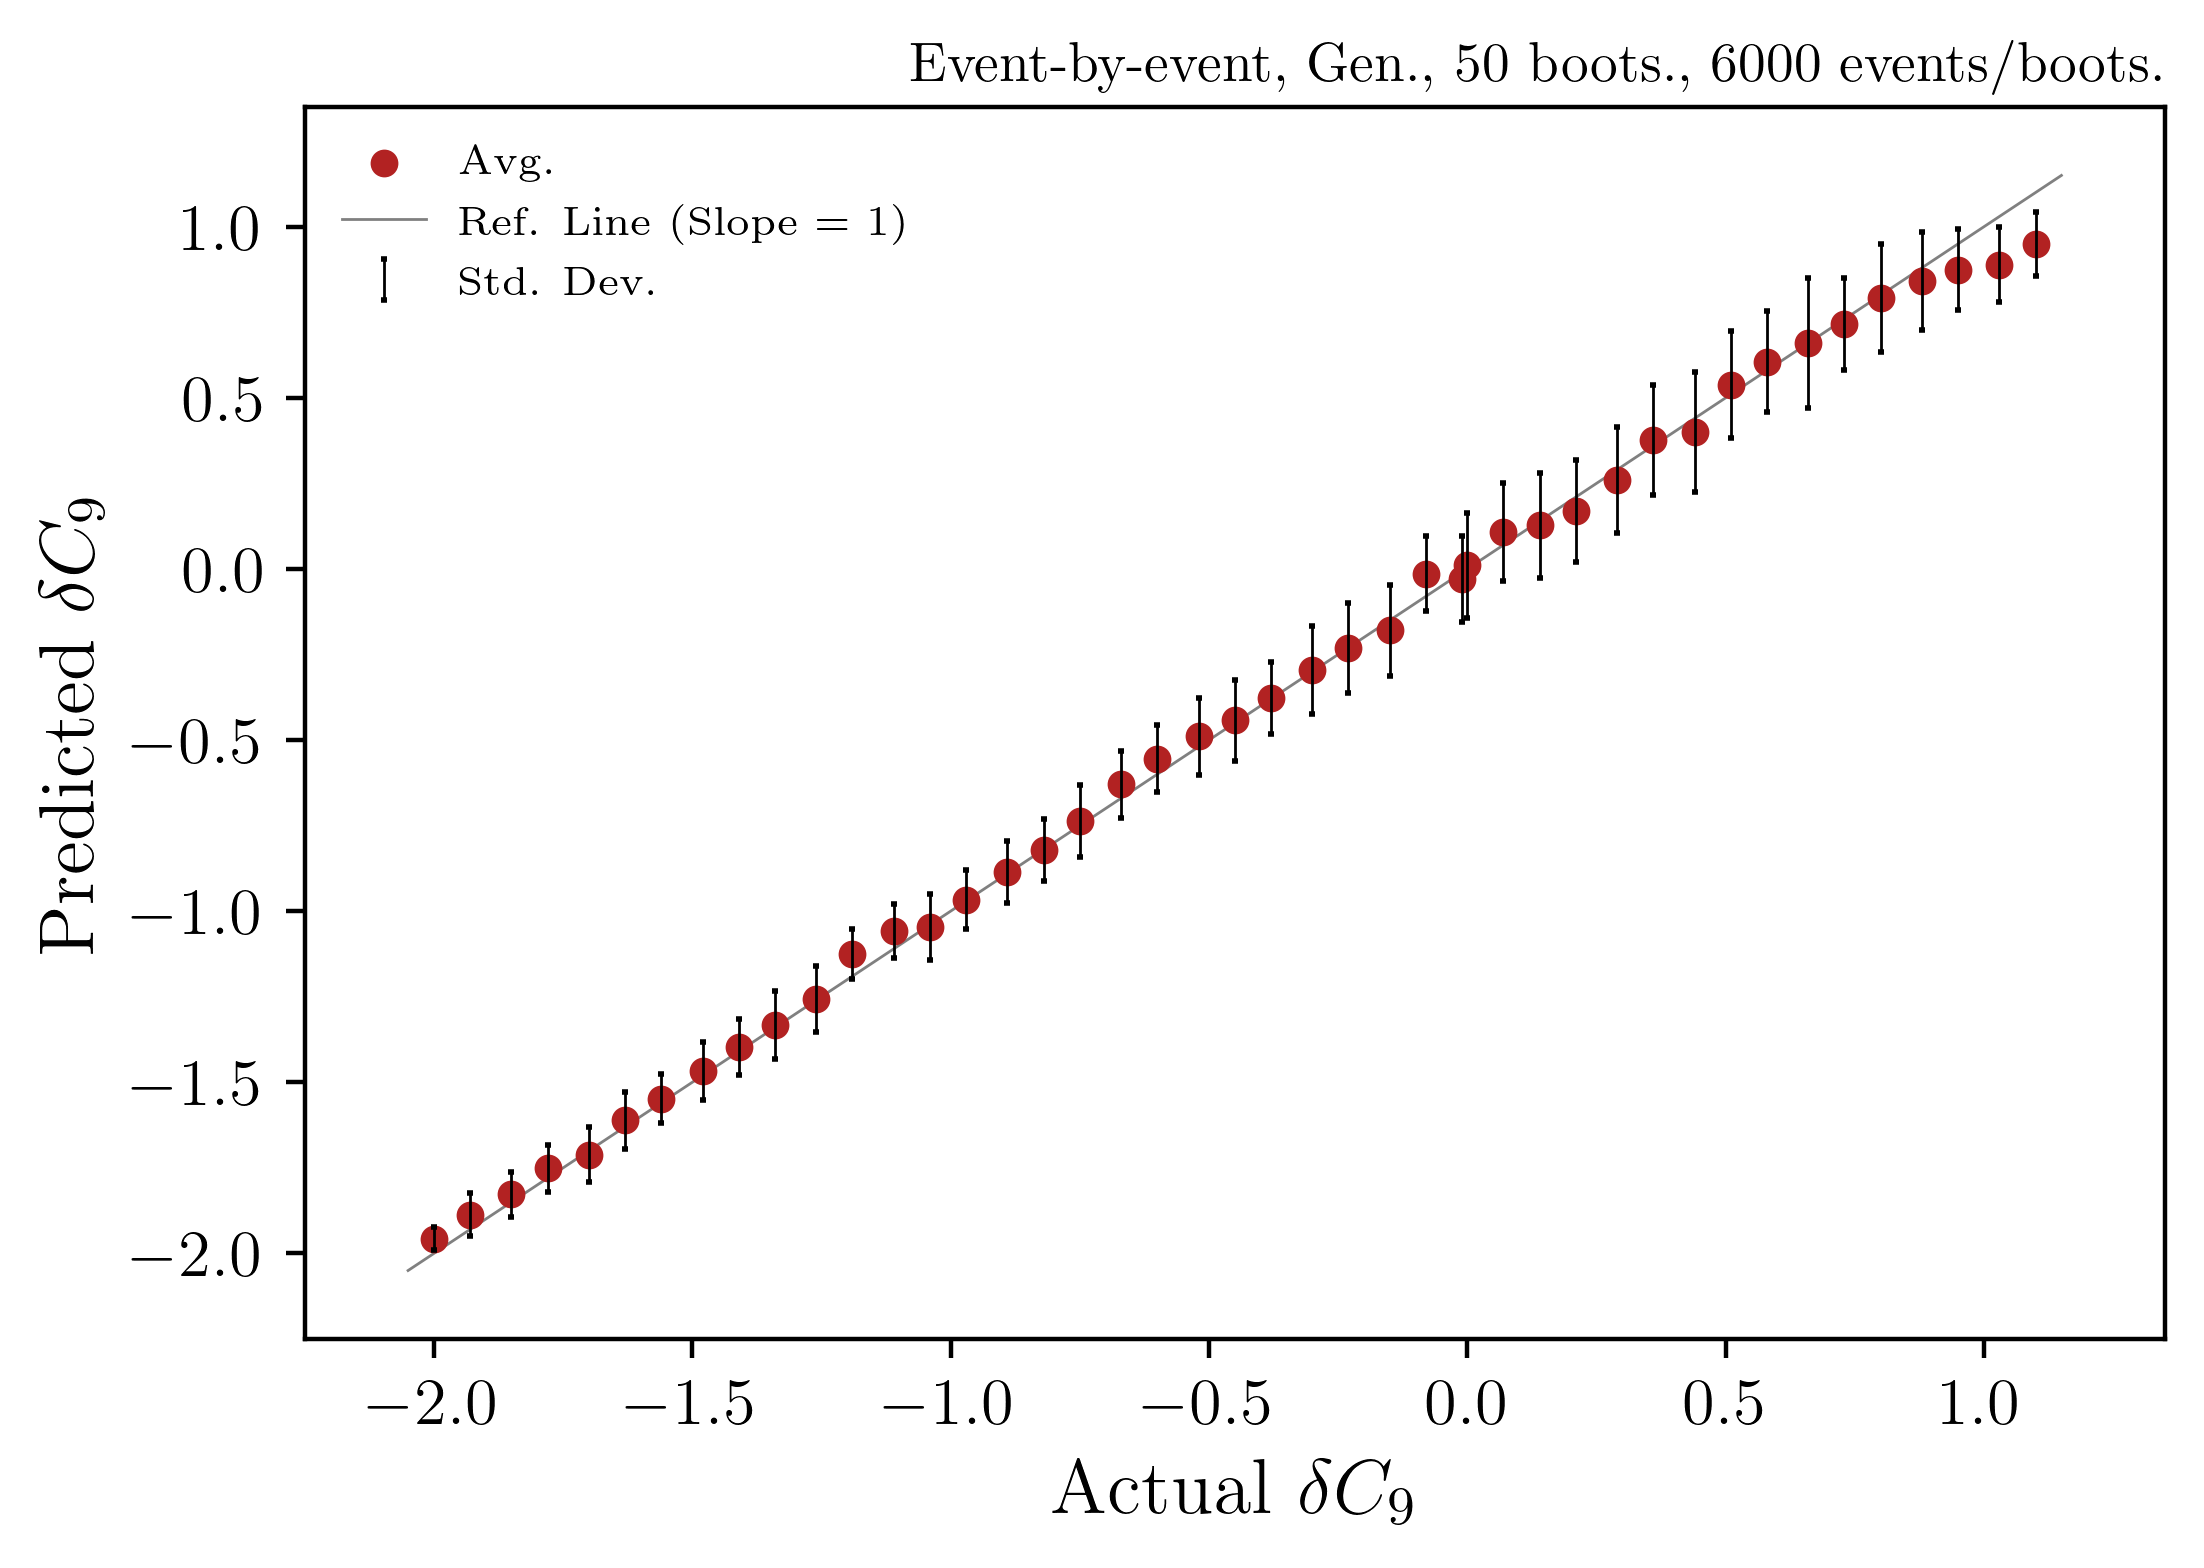

In [21]:
setup_high_quality_mpl_params()

fig, ax = plt.subplots()

plot_prediction_linearity(
    ax,
    datasets["eval"].bin_values,
    expected_values_all_trials_means,
    expected_values_all_trials_stds,
    ref_line_buffer=0.05,
    xlim=(-2.25, 1.35),
    ylim=(-2.25, 1.35),
    xlabel=r"Actual $\delta C_9$", 
    ylabel=r"Predicted $\delta C_9$"
)

make_plot_note(ax, f"Event-by-event, Gen., {n_trials} boots., {n_events_per_trial} events/boots.", fontsize="medium")

plt.show()

In [37]:
n_events_per_set = 6_000
n_sets = 2000

target_bin_index = np.argwhere(datasets["eval"].bin_values==-0.82).item()
rng = np.random.default_rng()

pool_x = datasets["eval"].features[datasets["eval"].labels==target_bin_index]
pool_y = datasets["eval"].labels[datasets["eval"].labels==target_bin_index]

yhats = []
for _ in range(n_sets):
    selection_indices = rng.choice(len(pool_x), n_events_per_set)
    boot_x = pool_x[selection_indices]
    boot_y = pool_y[selection_indices]

    log_probs = predict_log_probabilities(boot_x, model)
    bin_values = datasets["eval"].bin_values + 5
    log_bin_values = np.log(bin_values)
    lse = logsumexp(log_bin_values + log_probs.cpu().numpy())
    yhat = np.exp(lse) - 5
    yhats.append(yhat)
yhats

[np.float64(-0.8343899669473629),
 np.float64(-0.81953736871092),
 np.float64(-0.6134422691135022),
 np.float64(-0.8495889761424973),
 np.float64(-0.664210128116733),
 np.float64(-0.9059793805073539),
 np.float64(-0.7542412341001565),
 np.float64(-1.0614336878594135),
 np.float64(-0.7839059472537517),
 np.float64(-0.9673565734925749),
 np.float64(-0.8033219045516926),
 np.float64(-0.8376650434982906),
 np.float64(-0.80904709610419),
 np.float64(-0.9397194778478193),
 np.float64(-0.7605761880322373),
 np.float64(-0.7861997753241061),
 np.float64(-0.777188155655228),
 np.float64(-0.5786045753703943),
 np.float64(-0.7167024066350827),
 np.float64(-0.5804419812235393),
 np.float64(-0.9665307571518547),
 np.float64(-0.79556307419994),
 np.float64(-0.7885968470583116),
 np.float64(-0.9832004171982547),
 np.float64(-0.8705615033818228),
 np.float64(-0.8371805894017657),
 np.float64(-0.8605738917730488),
 np.float64(-0.7761035816923947),
 np.float64(-0.7809709758026182),
 np.float64(-0.7473465

In [38]:
yhats = np.array(yhats)
yhats

array([-0.83438997, -0.81953737, -0.61344227, ..., -0.77460743,
       -0.8113121 , -0.9736615 ])

In [39]:
mean= yhats.mean()
std = yhats.std()

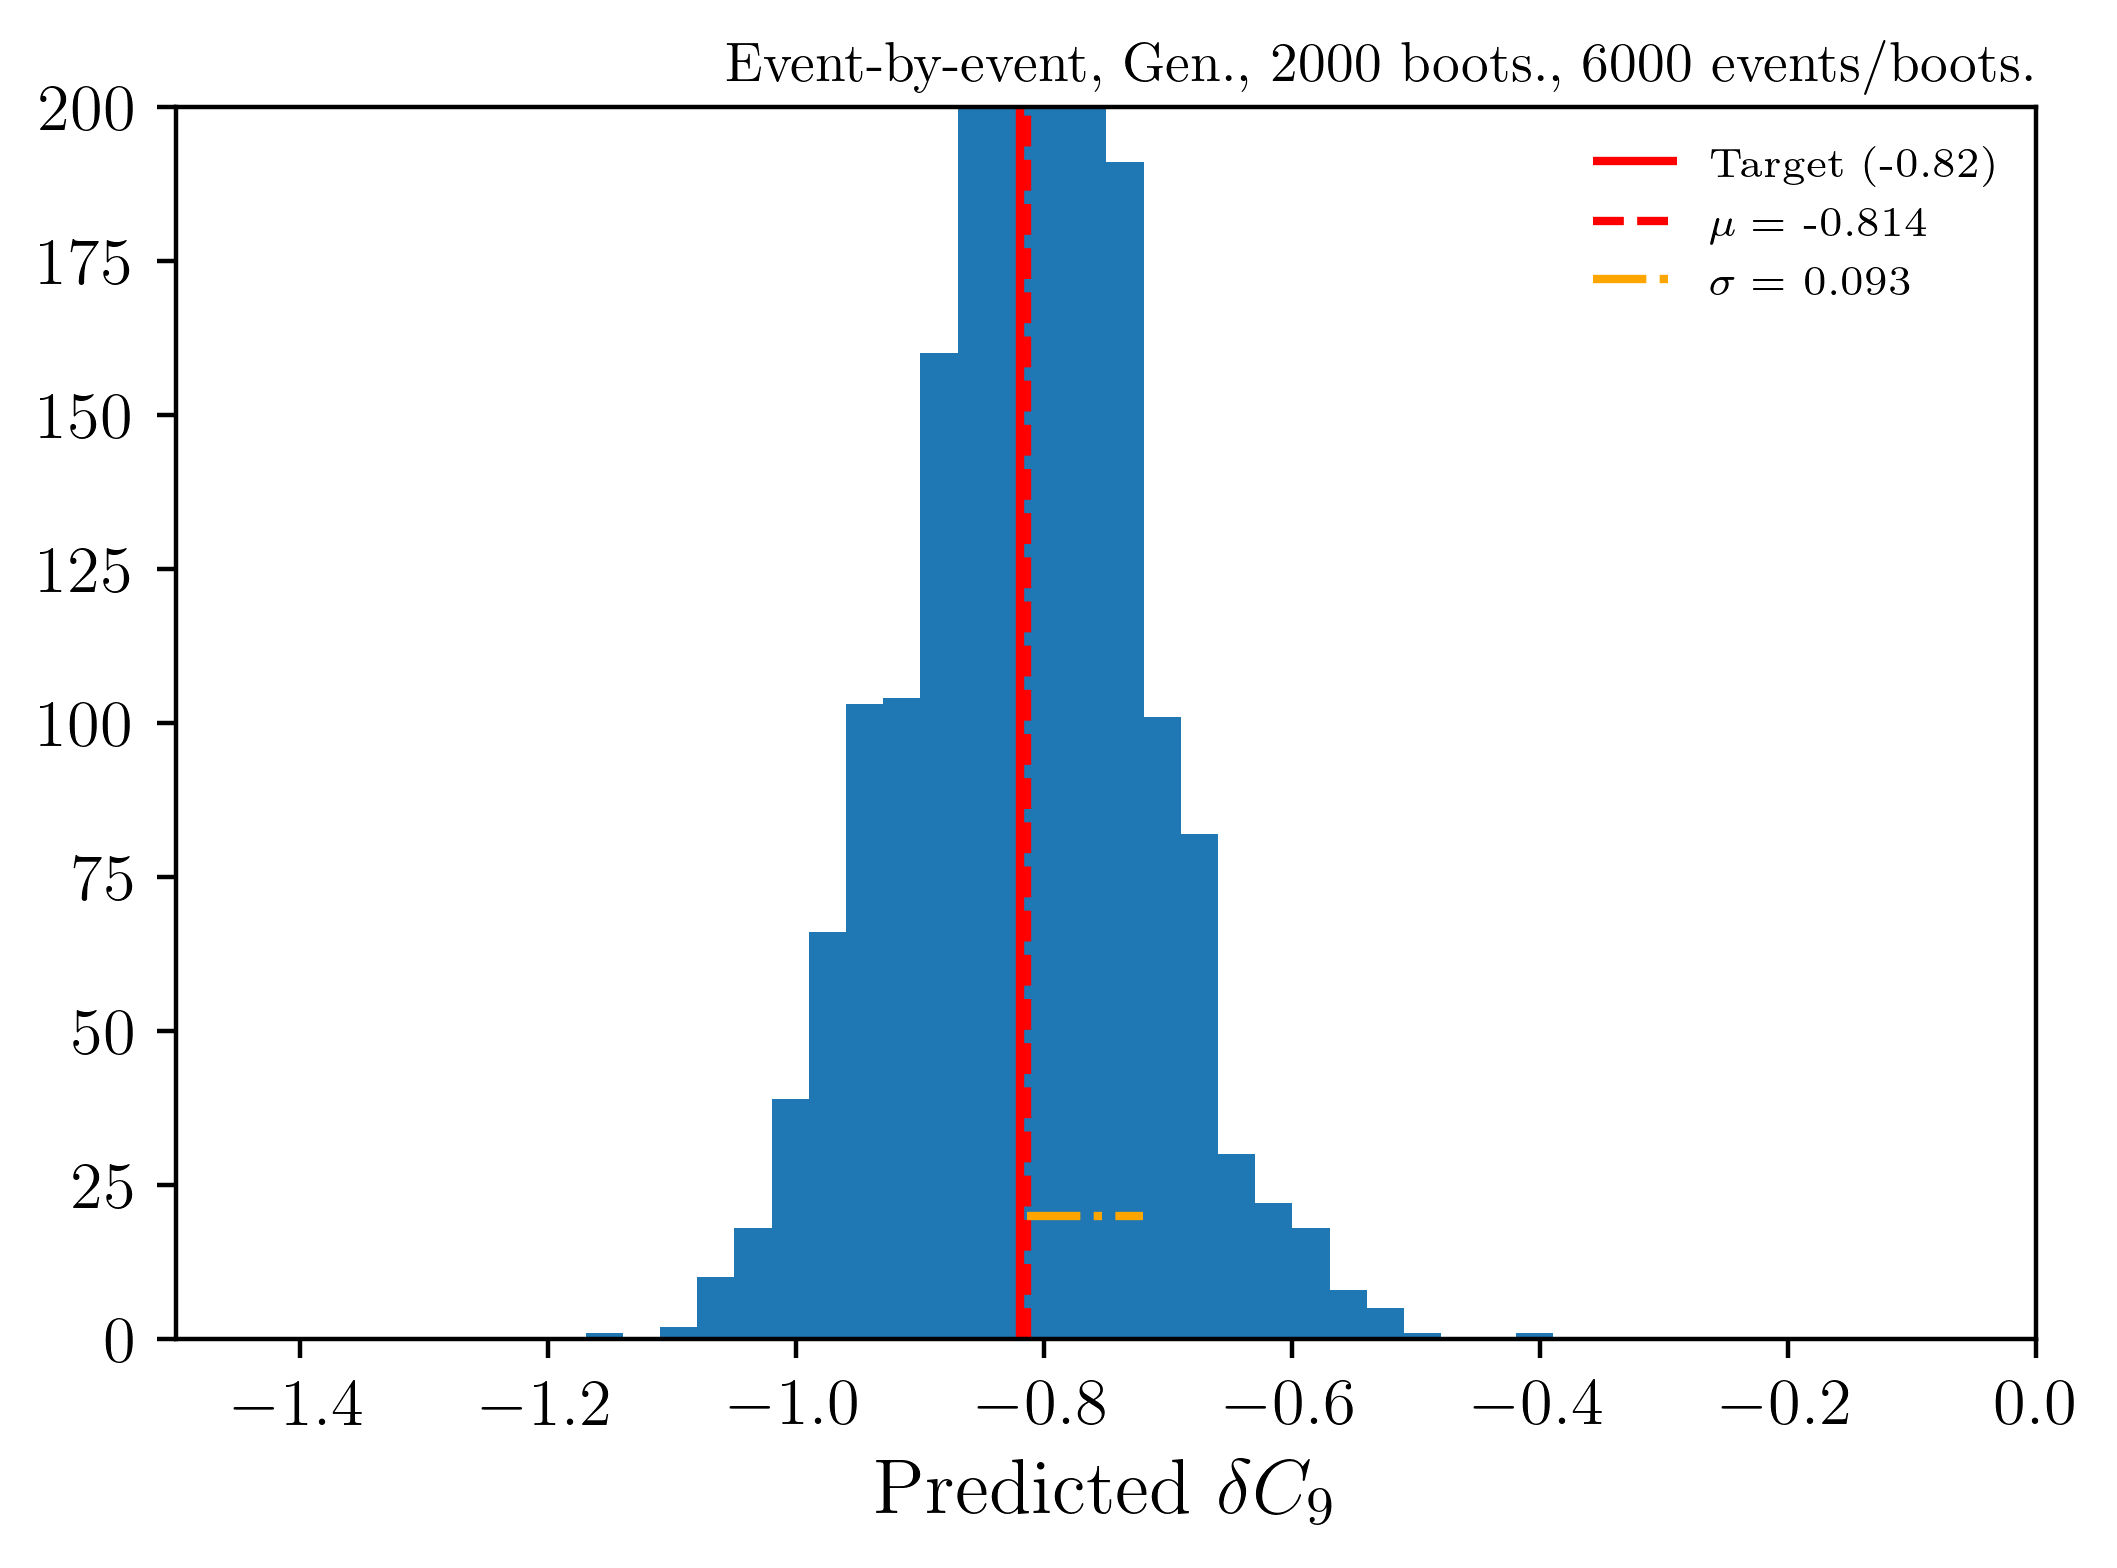

In [40]:
setup_high_quality_mpl_params()
fig, ax = plt.subplots()

xbounds = (-1.5, 0)
ybounds = (0, 200)

ax.hist(yhats, bins=50, range=xbounds)
ax.vlines(-0.82, 0, ybounds[1], color="red", label="Target (-0.82)")
ax.vlines(mean, 0, ybounds[1], color="red", linestyles="--", label=r"$\mu = $ "+f"{mean.round(3)}")
ax.hlines(20, mean, mean+std, color="orange", linestyles="dashdot", label=r"$\sigma = $ "+f"{std.round(3)}")
ax.set_xlabel(r"Predicted $\delta C_9$")
make_plot_note(ax, f"Event-by-event, Gen., {n_sets} boots., {n_events_per_set} events/boots.", fontsize="medium")
ax.set_xbound(*xbounds)
ax.set_ybound(*ybounds)
ax.legend()


plt.show()